### FactRuEval example

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

### 0. Download pretrained bert model
Download pretrained bert [here](https://storage.googleapis.com/bert_models/2018_11_03/multilingual_L-12_H-768_A-12.zip) and unzip.

Use the following code for convert tensorflow model to pytorch:


```export BERT_BASE_DIR=/path/to/bert/multilingual_L-12_H-768_A-12```

```python3 convert_tf_checkpoint_to_pytorch.py \```

```  --tf_checkpoint_path $BERT_BASE_DIR/bert_model.ckpt \ ```

```  --bert_config_file $BERT_BASE_DIR/bert_config.json \```

```  --pytorch_dump_path $BERT_BASE_DIR/pytorch_model.bin```

In [2]:
import os


data_path = "/home/lis/ner/ulmfit/data/factrueval/"
train_path = os.path.join(data_path, "train_with_pos.csv")
valid_path = os.path.join(data_path, "valid_with_pos.csv")
model_dir = "/datadrive/models/multilingual_L-12_H-768_A-12/"
init_checkpoint_pt = "/datadrive/models/multilingual_L-12_H-768_A-12/pytorch_model.bin"
bert_config_file = os.path.join(model_dir, "bert_config.json")
vocab_file = os.path.join(model_dir, "vocab.txt")

In [3]:
import torch
torch.cuda.set_device(1)
torch.cuda.is_available(), torch.cuda.current_device()

(True, 1)

### 1. Data preparation

Data train and validation should be presented in the following format.

In [4]:
import pandas as pd


df = pd.read_csv(train_path)
df.head()

,0,1,3
0,O O O O O O O O O O O O O O O O O O O O,"Мифология солнцеворота , собственно , и сводит...",NOUN NOUN PNCT ADVB PNCT CONJ VERB PREP NOUN N...
1,O O O O O O B_ORG I_ORG O B_ORG I_ORG O O O O ...,"По его словам , с покупкой Caramba TV « СТС Ме...",PREP NPRO NOUN PNCT PREP NOUN <unk> <unk> PNCT...
2,O O O O O O O O O O O O O O O O B_LOC O,"Такое десятилетие , по его словам « необходимо...",ADJF NOUN PNCT PREP NPRO NOUN PNCT ADJS ADJF P...
3,O O O O O O O O O O O O O O,"Правительство уволило часть врачей , обвинив и...",NOUN VERB NOUN NOUN PNCT GRND NPRO PREP NOUN N...
4,O O O B_PER I_PER O O O O O O B_ORG I_ORG I_OR...,Министр сельского хозяйства Николай Федоров пр...,NOUN ADJF NOUN NOUN NOUN VERB PNCT CONJ PRTF V...


Train and valid .csv files must have columns named (0, 1). Column 3 is't necessary (does not used now).
* Column 0 contains labels in IOB format.
* Column 1 contains tokenized and separated (by whitespace) text.

For using data in model we need to create `NerData` object.

* `train_path` - path to train .csv file
* `valid_path` - path to valid .csv file
* `vocab_file` - path to google bert pretrained vocab
* `label2idx` - mapping labales to indecies. Note, that we must place (for calc best f1-metric in a train cycle) labels in the folowwing order: `'{<pad>': 0, '[CLS]': 1, '[SEP]': 2, 'your_own_label1: num1, ...}'`
* `batch_size` - batch size (default `16`)
* `cuda` - using cuda or cpu (default `True`)

In [5]:
from modules.data import NerData
from modules.data import label2idx

For factrueval we use the following sample of labels:

In [6]:
print(label2idx)

{'<pad>': 0, '[CLS]': 1, '[SEP]': 2, 'B_O': 3, 'I_O': 4, 'B_LOC': 5, 'I_LOC': 6, 'B_ORG': 7, 'I_ORG': 8, 'B_PER': 9, 'I_PER': 10}


In [7]:
data = NerData.create(train_path, valid_path, vocab_file, label2idx)

### 2. Create model
For creating pytorch model we need to create `NerModel` object.

Pretrained params:
* `bert_config_file` - path to google bert pretrained config
* `init_checkpoint_pt` - path to google bert pretrained weights(?)
* `freeze_enc` - freezing bert encoder (default `True`)
* `bert_mode` - mode of how bert output will be returned. If `last` return the output of last layer. If `weighted` return weighted sum of all bert output layers, weights are learnable (aka ELMO).

Decoder params:
* `tag_size` - number of labels: `len(data.id2label)`
* `embedding_dim` - output dim from encoder (default `768`)
* `dropout_ratio` - dropout param (default `0.4`)
* `use_hidden` - using linear layer after lstm (default `True`)
* `use_rnn` - using rnn (default `True`)
* `hidden_dim` - dim of rnn layer or hidden layer (default `128`)
* `rnn_layers` - number of rnn layers (default `1`)

MultiheadAttention Layer params
* `num_heads` - number of heads (default `3`)
* `dropout_attn` - dropout for atention (default `0.1`)
* `key_dim` - keyword dim in attention (default `64`)
* `val_dim` - value dim (default `64`)
* `use_attn` - include attention layer to model (defalut `False`) 

Gpu or cpu:
* `use_cuda` - use cuda or cpu (default `True`).

In [8]:
from modules.model import NerModel

In [9]:
model = NerModel.create(bert_config_file, init_checkpoint_pt, len(data.id2label), use_rnn=True, use_attn=True,
                        bert_mode="weighted")

Use rnn of type: lstm with n_layers: 1
Use MultiHeadAttention layer with num_heads 3
Use fully-connected layer before crf.
freeze_encoder


### 3. Create learner

For training our pytorch model we need to create `NerLearner` object.

* `model: NerModel` - pytorch model
* `sup_labels` - list of supported labels for calculating f1 metric. For FactRuEval use: `['B_LOC', 'I_LOC', 'B_ORG', 'I_ORG', 'B_PER', 'I_PER']`
* `base_lr` - starting learning rate (default `0.001`)
* `lr_max` - max learning rate for scheduler (default `0.01`)
* `betas` - params for default optimizer (default `[0.8, 0.9]`)
* `clip` - grad clipping (default `0.25`)
* `verbose` - printing to console reports (default `True`)

In [13]:
from modules.train import NerLearner

In [14]:
learner = NerLearner(model, data.id2label[5:], data,
                     best_model_path="/datadrive/models/factrueval/exp_attn2.cpt",
                     base_lr=0.001, lr_max=0.01, clip=5.0, use_lr_scheduler=True)

11/26/2018 09:18:35 - INFO - root -   Use lr OneCycleScheduler...


### 4. Learn your NER model
Call `learner.fit`
* `epochs` - number of train iterations (default `100`)
* `resume_history` - resuming appending results to history or create new (default `True`)
* `target_metric` - mean metric, that want you see to pick best epochs (default `f1`).

In [ ]:
learner.fit(5, target_metric='prec')

In [18]:
from modules.plot_metrics import plot_by_class_curve

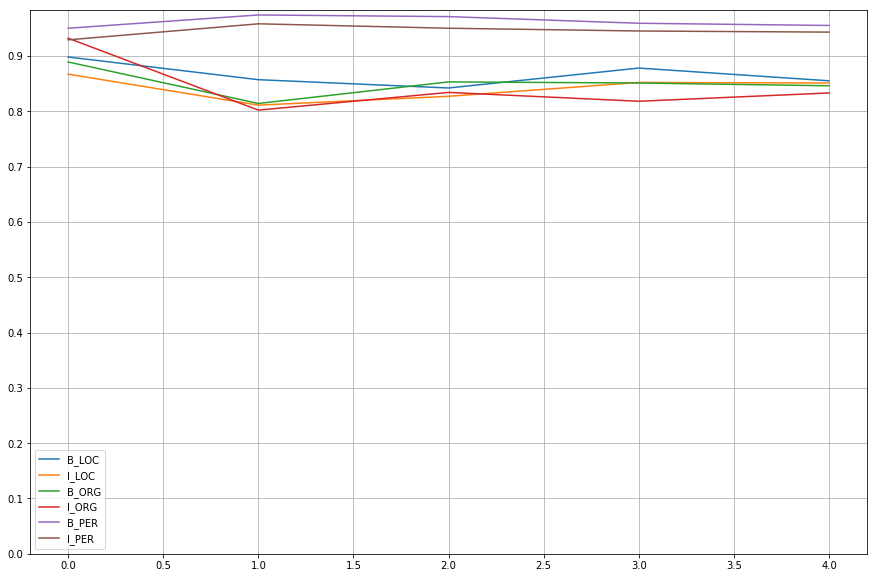

In [19]:
plot_by_class_curve(learner.history, 'prec', data.id2label[5:])

### 5. Predict on new data
Create new data loader from existing path.

In [20]:
from modules.data import get_data_loader_for_predict

In [21]:
dl, orig_to_tok_map = get_data_loader_for_predict(data_path+"valid.csv", learner)

Load our best model.

In [22]:
learner.load_model()

Call predict from learner.

In [23]:
preds = learner.predict(dl)

### 6. Transform predictions to tokens and spans

In [24]:
from modules.utils import to_words, tokens2spans


tokens, labels = to_words(dl, orig_to_tok_map, preds)

In [25]:
spans = tokens2spans(tokens, labels)

In [26]:
print(tokens[0])

['сделка', 'состоится', ',', 'если', 'будет', 'одобрена', 'регуляторами', ',', 'из-за', 'которых', 'в', 'начале', 'года', 'сорвалось', 'слияние', 'nyse', 'euronext', 'с', 'deutsche', 'borse']


Predicted labels

In [27]:
print(labels[0])

['B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_ORG', 'B_ORG', 'B_O', 'B_ORG', 'B_ORG']


Origin labels

In [28]:
tokens, labels = to_words(dl, orig_to_tok_map, [x.labels for x in dl.dataset])

In [29]:
print(labels[0])

['B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_O', 'B_ORG', 'B_ORG', 'B_O', 'B_ORG', 'B_ORG']


Predicted spans

In [30]:
print(spans[0])

[('сделка', 'O'), ('состоится', 'O'), (',', 'O'), ('если', 'O'), ('будет', 'O'), ('одобрена', 'O'), ('регуляторами', 'O'), (',', 'O'), ('из-за', 'O'), ('которых', 'O'), ('в', 'O'), ('начале', 'O'), ('года', 'O'), ('сорвалось', 'O'), ('слияние', 'O'), ('nyse', 'ORG'), ('euronext', 'ORG'), ('с', 'O'), ('deutsche', 'ORG'), ('borse', 'ORG')]


Origin spans

In [31]:
spans = tokens2spans(tokens, labels)

In [32]:
print(spans[0])

[('сделка', 'O'), ('состоится', 'O'), (',', 'O'), ('если', 'O'), ('будет', 'O'), ('одобрена', 'O'), ('регуляторами', 'O'), (',', 'O'), ('из-за', 'O'), ('которых', 'O'), ('в', 'O'), ('начале', 'O'), ('года', 'O'), ('сорвалось', 'O'), ('слияние', 'O'), ('nyse', 'ORG'), ('euronext', 'ORG'), ('с', 'O'), ('deutsche', 'ORG'), ('borse', 'ORG')]


In [33]:
from modules.plot_metrics import get_span_report
clf_report = get_span_report(dl, orig_to_tok_map, preds)
print(clf_report)

              precision    recall  f1-score   support

         PER      0.943     0.935     0.939       321
         ORG      0.893     0.571     0.697       543
         LOC      0.892     0.609     0.724       230

   micro avg      0.912     0.686     0.783      1094
   macro avg      0.909     0.705     0.786      1094
weighted avg      0.908     0.686     0.773      1094



### 7. Fit factrueval for best metric

In [415]:
model = NerModel.create(bert_config_file, init_checkpoint_pt, len(data.id2label), hidden_dim=128)

freeze_encoder


In [416]:
learner = NerLearner(
    model,
    data.id2label[5:],
    data,
    lr=0.001,
    clip=5.0,
    best_model_path="/datadrive/models/factrueval/best_model.cpt")

11/20/2018 15:35:40 - INFO - root -   Don't use lr scheduler...


In [ ]:
learner.fit(300, target_metric='prec')

### 8. Evaluate
Note: The following result can be improved!

In [422]:
dl, orig_to_tok_map = get_data_loader_for_predict(data_path+"valid.csv", learner)
learner.load_model()
preds = learner.predict(dl)

#### Evaluate tokens

In [423]:
from modules.plot_metrics import *

In [437]:
get_mean_max_metric(learner.history, data.id2label[5:], "prec", True)

(63, 0.9341666666666667)

#### Evaluate spans

In [431]:
from modules.plot_metrics import get_span_report

In [433]:
clf_report = get_span_report(dl, orig_to_tok_map, preds)

In [434]:
print(clf_report)

              precision    recall  f1-score   support

         LOC      0.885     0.504     0.643       230
         ORG      0.898     0.727     0.804       543
         PER      0.928     0.888     0.908       321

   micro avg      0.907     0.728     0.807      1094
   macro avg      0.904     0.707     0.785      1094
weighted avg      0.904     0.728     0.800      1094

